In [45]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import warnings
import datetime
import math
from matplotlib import pyplot

from sklearn.metrics import mean_squared_error,mean_absolute_error,r2_score
from sklearn import preprocessing
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LinearRegression
from xgboost.sklearn import XGBRegressor

warnings.filterwarnings('ignore')

# Reading the cleaned file

In [46]:
df = pd.read_csv('data/books_cleaned_from_project_ipynb.csv', on_bad_lines='warn')

In [47]:
df.sample(1)

,bookID,title,authors,average_rating,language_code,num_pages,ratings_count,text_reviews_count,publication_date,publisher
8508,32668,LT's Theory of Pets,Stephen King,3.69,eng,1,2824,140,8/1/2001,Simon Schuster Audio


# Feature Engineering

## Drop duplicates

In [48]:
print(df.shape)
df = df.drop_duplicates(subset=['title'])
print(df.shape)

(11127, 10)
(10352, 10)


## Outliers

{'whiskers': [<matplotlib.lines.Line2D at 0x22de20d0450>,
 'caps': [<matplotlib.lines.Line2D at 0x22de20cf690>,
 'boxes': [<matplotlib.lines.Line2D at 0x22de20d0e10>],
 'medians': [<matplotlib.lines.Line2D at 0x22de20ce410>],
 'fliers': [<matplotlib.lines.Line2D at 0x22de20cd810>],
 'means': []}

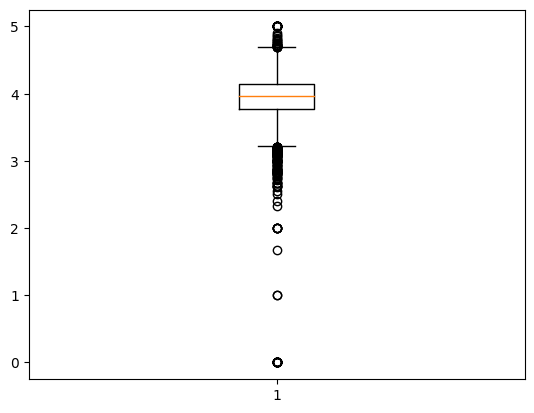

In [49]:
plt.boxplot(df['average_rating'])

{'whiskers': [<matplotlib.lines.Line2D at 0x22de20a1750>,
 'caps': [<matplotlib.lines.Line2D at 0x22de20a1bd0>,
 'boxes': [<matplotlib.lines.Line2D at 0x22de20a5550>],
 'medians': [<matplotlib.lines.Line2D at 0x22de20a1f90>],
 'fliers': [<matplotlib.lines.Line2D at 0x22de20a2250>],
 'means': []}

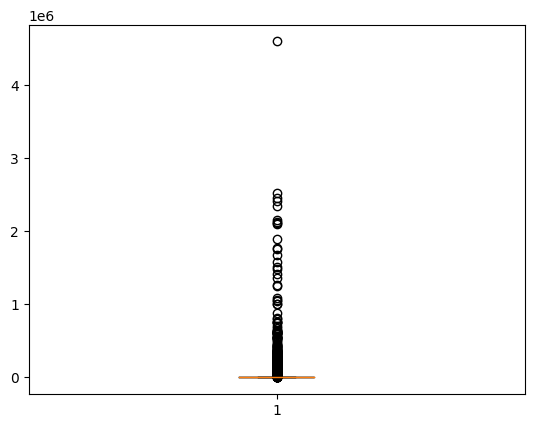

In [50]:
plt.boxplot(df['ratings_count'])

In [51]:
print(df.shape)
df= df.drop(df.index[df['ratings_count'] >= 1000000])
print(df.shape)

(10352, 10)
(10328, 10)


{'whiskers': [<matplotlib.lines.Line2D at 0x22de1f28f90>,
 'caps': [<matplotlib.lines.Line2D at 0x22de1f23e90>,
 'boxes': [<matplotlib.lines.Line2D at 0x22de2028410>],
 'medians': [<matplotlib.lines.Line2D at 0x22de1f227d0>],
 'fliers': [<matplotlib.lines.Line2D at 0x22de1ff0d10>],
 'means': []}

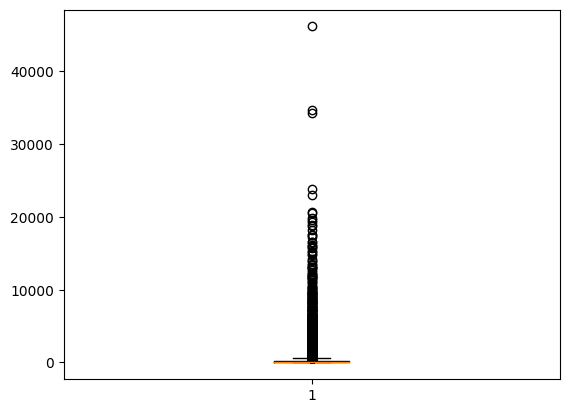

In [52]:
plt.boxplot(df['text_reviews_count'])

In [53]:
print(df.shape)
df = df.drop(df.index[df['text_reviews_count'] >= 20000])
print(df.shape)

(10328, 10)
(10321, 10)


{'whiskers': [<matplotlib.lines.Line2D at 0x22de2039b90>,
 'caps': [<matplotlib.lines.Line2D at 0x22de2038710>,
 'boxes': [<matplotlib.lines.Line2D at 0x22de203a910>],
 'medians': [<matplotlib.lines.Line2D at 0x22de2097650>],
 'fliers': [<matplotlib.lines.Line2D at 0x22de20b4f10>],
 'means': []}

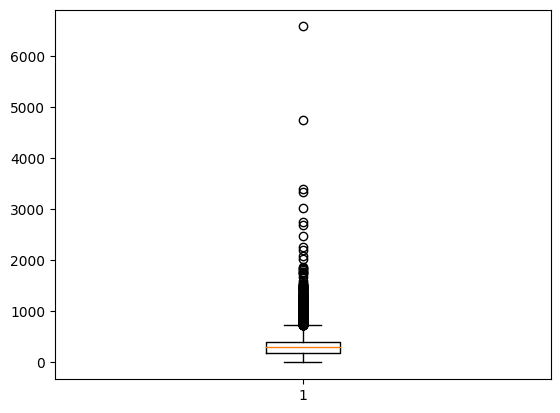

In [54]:
plt.boxplot(df['num_pages'])

In [55]:
print(df.shape)
df = df.drop(df.index[df['text_reviews_count'] >= 2000])
print(df.shape)

(10321, 10)
(9801, 10)


## Language

### Modify lang code which appear the least and replace by "others" 

In [56]:
df['language_code'].value_counts()

language_code
eng      7752
en-US    1305
spa       197
en-GB     190
fre       132
ger        94
jpn        46
mul        19
zho        14
grc        11
por        10
en-CA       7
ita         5
lat         3
enm         3
rus         2
swe         2
nl          1
ara         1
srp         1
msa         1
glg         1
wel         1
nor         1
tur         1
gla         1
Name: count, dtype: int64

In [57]:
top_lang = df['language_code'].value_counts().head(6).index
top_lang

Index(['eng', 'en-US', 'spa', 'en-GB', 'fre', 'ger'], dtype='object', name='language_code')

In [58]:
mask = ~df['language_code'].isin(top_lang)
df.loc[mask,'language_code'] = 'others'

In [59]:
df['language_code'].value_counts()

language_code
eng       7752
en-US     1305
spa        197
en-GB      190
fre        132
others     131
ger         94
Name: count, dtype: int64

### One-Hot-Encoding

In [60]:
df = pd.get_dummies(df
               ,columns = ['language_code']
               ,drop_first = True,
               dtype=int
               )

In [61]:
df.sample(1)

,bookID,title,authors,average_rating,num_pages,ratings_count,text_reviews_count,publication_date,publisher,language_code_en-US,language_code_eng,language_code_fre,language_code_ger,language_code_others,language_code_spa
3287,12048,The Sheltering Sky / Let It Come Down / The Sp...,Paul Bowles/Daniel Halpern,4.19,940,264,21,8/26/2002,Library of America,0,1,0,0,0,0


## Year

In [62]:
df['publication_date'] = pd.to_datetime(df['publication_date'], format='%m/%d/%Y', errors='coerce')

In [63]:
df.isnull().sum()

bookID                  0
title                   0
authors                 0
average_rating          0
num_pages               0
ratings_count           0
text_reviews_count      0
publication_date        2
publisher               0
language_code_en-US     0
language_code_eng       0
language_code_fre       0
language_code_ger       0
language_code_others    0
language_code_spa       0
dtype: int64

In [64]:
print(df.shape)
df.dropna(inplace=True)
print(df.shape)

(9801, 15)
(9799, 15)


In [65]:
df['publication_year'] = pd.DatetimeIndex(df['publication_date']).year

In [66]:
df.drop(columns=['publication_date'],inplace=True)

In [67]:
df.sample(1)

,bookID,title,authors,average_rating,num_pages,ratings_count,text_reviews_count,publisher,language_code_en-US,language_code_eng,language_code_fre,language_code_ger,language_code_others,language_code_spa,publication_year
3552,12922,The Castle of Otranto,Horace Walpole/E.F. Bleiler/Walter Scott,3.18,106,237,39,Dover Publications,0,1,0,0,0,0,2004


## Qualitative data to label

In [68]:
## Label encode title 
le = preprocessing.LabelEncoder()
df['title'] = le.fit_transform(df['title'])
df['title'].value_counts().head(10)

title
2908    1
231     1
6537    1
2108    1
8174    1
1674    1
8117    1
5188    1
5235    1
1982    1
Name: count, dtype: int64

In [69]:
## Label encode authors
df['authors'] = le.fit_transform(df['title'])
df['authors'].value_counts().head(10)

authors
2908    1
231     1
6537    1
2108    1
8174    1
1674    1
8117    1
5188    1
5235    1
1982    1
Name: count, dtype: int64

In [70]:
## Label encode authors
df['publisher'] = le.fit_transform(df['publisher'])
df['publisher'].value_counts().head(10)

publisher
2001    275
1388    197
1147    139
1403    137
170     130
841     100
1469     98
173      96
832      95
1970     87
Name: count, dtype: int64

In [71]:
df.sample(2)

,bookID,title,authors,average_rating,num_pages,ratings_count,text_reviews_count,publisher,language_code_en-US,language_code_eng,language_code_fre,language_code_ger,language_code_others,language_code_spa,publication_year
1976,7089,6307,6307,3.77,170,3856,119,1659,0,1,0,0,0,0,1997
5847,21972,5358,5358,4.02,473,152,41,298,0,1,0,0,0,0,2007


# Models 

## Create dictionnary to store result for each model

In [72]:
global_result = pd.DataFrame(columns=['model name','RMSE','mae','r2_score'])

## Create train / test dataset

In [73]:
df.dtypes

bookID                    int64
title                     int32
authors                   int64
average_rating          float64
num_pages                 int64
ratings_count             int64
text_reviews_count        int64
publisher                 int32
language_code_en-US       int32
language_code_eng         int32
language_code_fre         int32
language_code_ger         int32
language_code_others      int32
language_code_spa         int32
publication_year          int32
dtype: object

In [74]:
y = df.pop('average_rating')
X_train, X_test, y_train, y_test = train_test_split(df.drop(columns=['bookID']), y, test_size=0.3, random_state=42)

## Baseline  (Predict mean average rating)

In [75]:
len(y_test)

2940

In [76]:
mean_ratings = y_test.mean().round(2)
y_pred = np.full((len(y_test)), mean_ratings)
y_pred

array([3.93, 3.93, 3.93, ..., 3.93, 3.93, 3.93])

### Metrics

In [77]:
# calculate errors
errors = mean_squared_error(y_test,y_pred)
rmse = math.sqrt(errors)
print(f'RMSE : {rmse}')
mae = mean_absolute_error(y_test,y_pred)
print(f'mae : {mae}')
r2 = r2_score(y_test,y_pred).round(2)
print(f'r2_score : {r2}')


# Create dictionnary to aggregte all result 
dict = {'model name' : 'Baseline','RMSE':rmse,'mae':mae,'r2_score':r2 }
global_result.loc[len(global_result)] = pd.Series(data=dict,index=dict.keys())

RMSE : 0.36428417366621
mae : 0.23886054421768704
r2_score : -0.0


## Random Forest

## Linear Regression

## XGBoost

# Results